# Random Forest - Vishnuram

In this notebook, we will implement a random forest in Python. We'll start with a single decision tree and a simple problem, and then work our way to a random forest and a real-world problem.

In [69]:
import numpy as np
import pandas as pd

# Set random seed to ensure reproducible runs
RSEED = 50

# Start Simple: Basic Problem


First, we create the features `X` and the labels `y`. There are only two features, which will allow us to visualize the data and which makes this a very easy problem.

In [70]:
X = np.array([[2, 2],
              [2, 1],
              [2, 3],
              [1, 2],
              [1, 1],
              [3, 3]])

y = np.array([0, 1, 1, 1, 0, 1])

### Data Visualization

To get a sense of the data, we can graph the data points with the number showing the label.

Text(0.5, 1.0, 'Data')

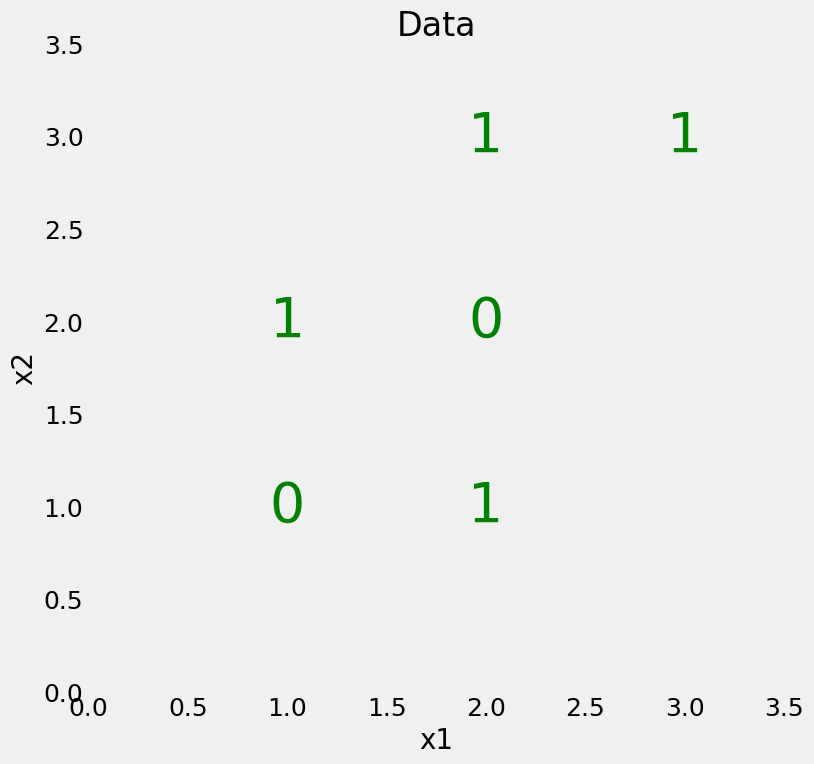

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.figure(figsize = (8, 8))

# Plot each point as the label
for x1, x2, label in zip(X[:, 0], X[:, 1], y):
    plt.text(x1, x2, str(label), fontsize = 40, color = 'g',
             ha='center', va='center')

# Plot formatting
plt.grid(None);
plt.xlim((0, 3.5));
plt.ylim((0, 3.5));
plt.xlabel('x1', size = 20); plt.ylabel('x2', size = 20); plt.title('Data', size = 24)

This is a linearly inseparable problem. A simple linear classifier will not be able to draw a boundary that separates the classes. The single decision tree will be able to completely separate the points because it essentially draws many repeated linear boundaries between points. A decision tree is a non-parametric model because the number of parameters grows with the size of the data.

## Single Decision Tree

Here we quickly build and train a single decision tree on the data using Scikit-Learn. At each stage, the decision tree makes splits by maximizing the reduction in Gini impurity.


In [72]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(criterion='entropy',random_state=RSEED)
tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=50)

In [73]:
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 9 nodes with maximum depth 3.


Our decision tree formed 9 nodes and reached a maximum depth of 3. It will have achieved 100% accuracy on the training data because we did not limit the depth and it therefore can classify every _training_ point perfectly.

In [74]:
print(f'Model Accuracy: {tree.score(X, y)}')

Model Accuracy: 1.0


## Visualize Decision Tree

We visualize the tree now, we can do so because the tree is relatively small, we can understand the entire image.
First we export the tree as a `dot` file making sure to label the features and the classes.

In [75]:
from sklearn.tree import export_graphviz

# Export as dot
export_graphviz(tree, 'tree.dot', rounded = True,
                feature_names = ['x1', 'x2'],
                class_names = ['0', '1'], filled = True)

Next we use a system command and the Graphziv `dot` function to convert to a `png` (image). This requires Graphviz to be installed on your computer.

In [76]:
# from subprocess import call
# # Convert to png
# call(['dot', '-Tpng', 'C:/Vishnu/semester Files/Machine Learning TA/Decision trees and random forest/tree.dot', '-o', 'tree.png', '-Gdpi=400']);

import os
from subprocess import call

# Path to the .dot file
dot_file_path = r"C:\Vishnu\semester Files\Machine Learning TA\Decision trees and random forest\tree.dot"
# Output path for the .png file
output_png_path = 'tree.png'

# Ensure the .dot file exists
if os.path.exists(dot_file_path):
    # Convert to PNG
    call(['dot', '-Tpng', dot_file_path, '-o', output_png_path, '-Gdpi=400'])
    print(f'Successfully converted {dot_file_path} to {output_png_path}')
else:
    print(f'The file {dot_file_path} does not exist.')


The file C:\Vishnu\semester Files\Machine Learning TA\Decision trees and random forest\tree.dot does not exist.


Finally, we display the entire tree.

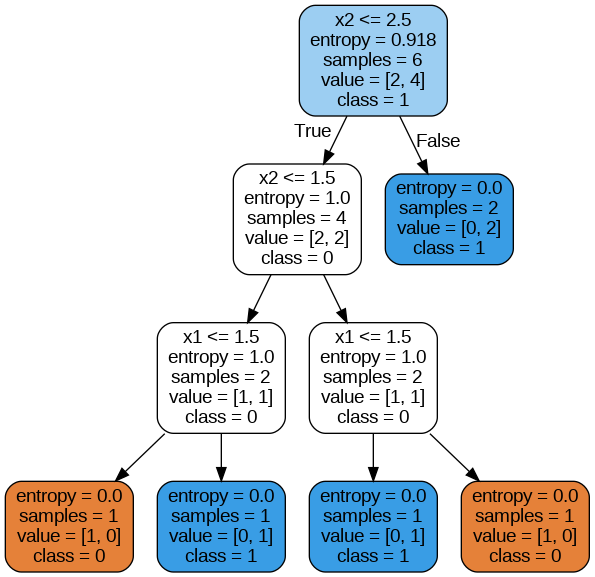

In [77]:
from IPython.display import Image
Image('tree.png')

Decision Tree Structure

A decision tree functions as a flowchart for classification.

 Question: The feature-based condition for splitting.

 Gini: The impurity score (probability of misclassification).

 Samples: Total data points in the node.

 Value: The count of samples per class.

 Class: The predicted category at that depth.

### Gini Impurity

<!-- The Gini Impurity represents the probability that a randomly selected sample from the node will be incorrectly classified according to the distribution of samples in the node. At the top, there is a 44.4% chance that a randomly selected point would be incorrectly classified. The Gini Impurity is how the decision tree makes splits. It splits the samples based on the value of a feature that reduces the Gini Impurity by the largest amount.
If we do the math, the average (weighted by number of samples) Gini Impurity decreases as we move down the tree.

Eventually, the average Gini Impurity goes to 0.0 as we correctly classify each point. However, correctly classifying every single training point is usually not a good indicator because that means the model will not be able to generalize to the testing data! This model correclty classifies every single training point because we did not limit the maximum depth and during training, we give the model the answers as well as the features. -->


Gini Impurity quantifies the probability of misclassifying a random sample and guides the decision tree to create splits that most effectively reduce this disorder. Although the tree can continue splitting until it achieves an impurity of 0.0 and perfectly classifies the training set, this usually indicates the model has memorized the data rather than learning from it.

To prevent this overfitting and ensure the model generalizes well to unseen testing data, it is crucial to limit the tree's maximum depth.


In [78]:
# Limit maximum depth and train
short_tree = DecisionTreeClassifier(max_depth = 2, random_state=RSEED)
short_tree.fit(X, y)

print(f'Model Accuracy: {short_tree.score(X, y)}')

Model Accuracy: 0.6666666666666666


We can do the same as before, visualizing the entire decision tree.

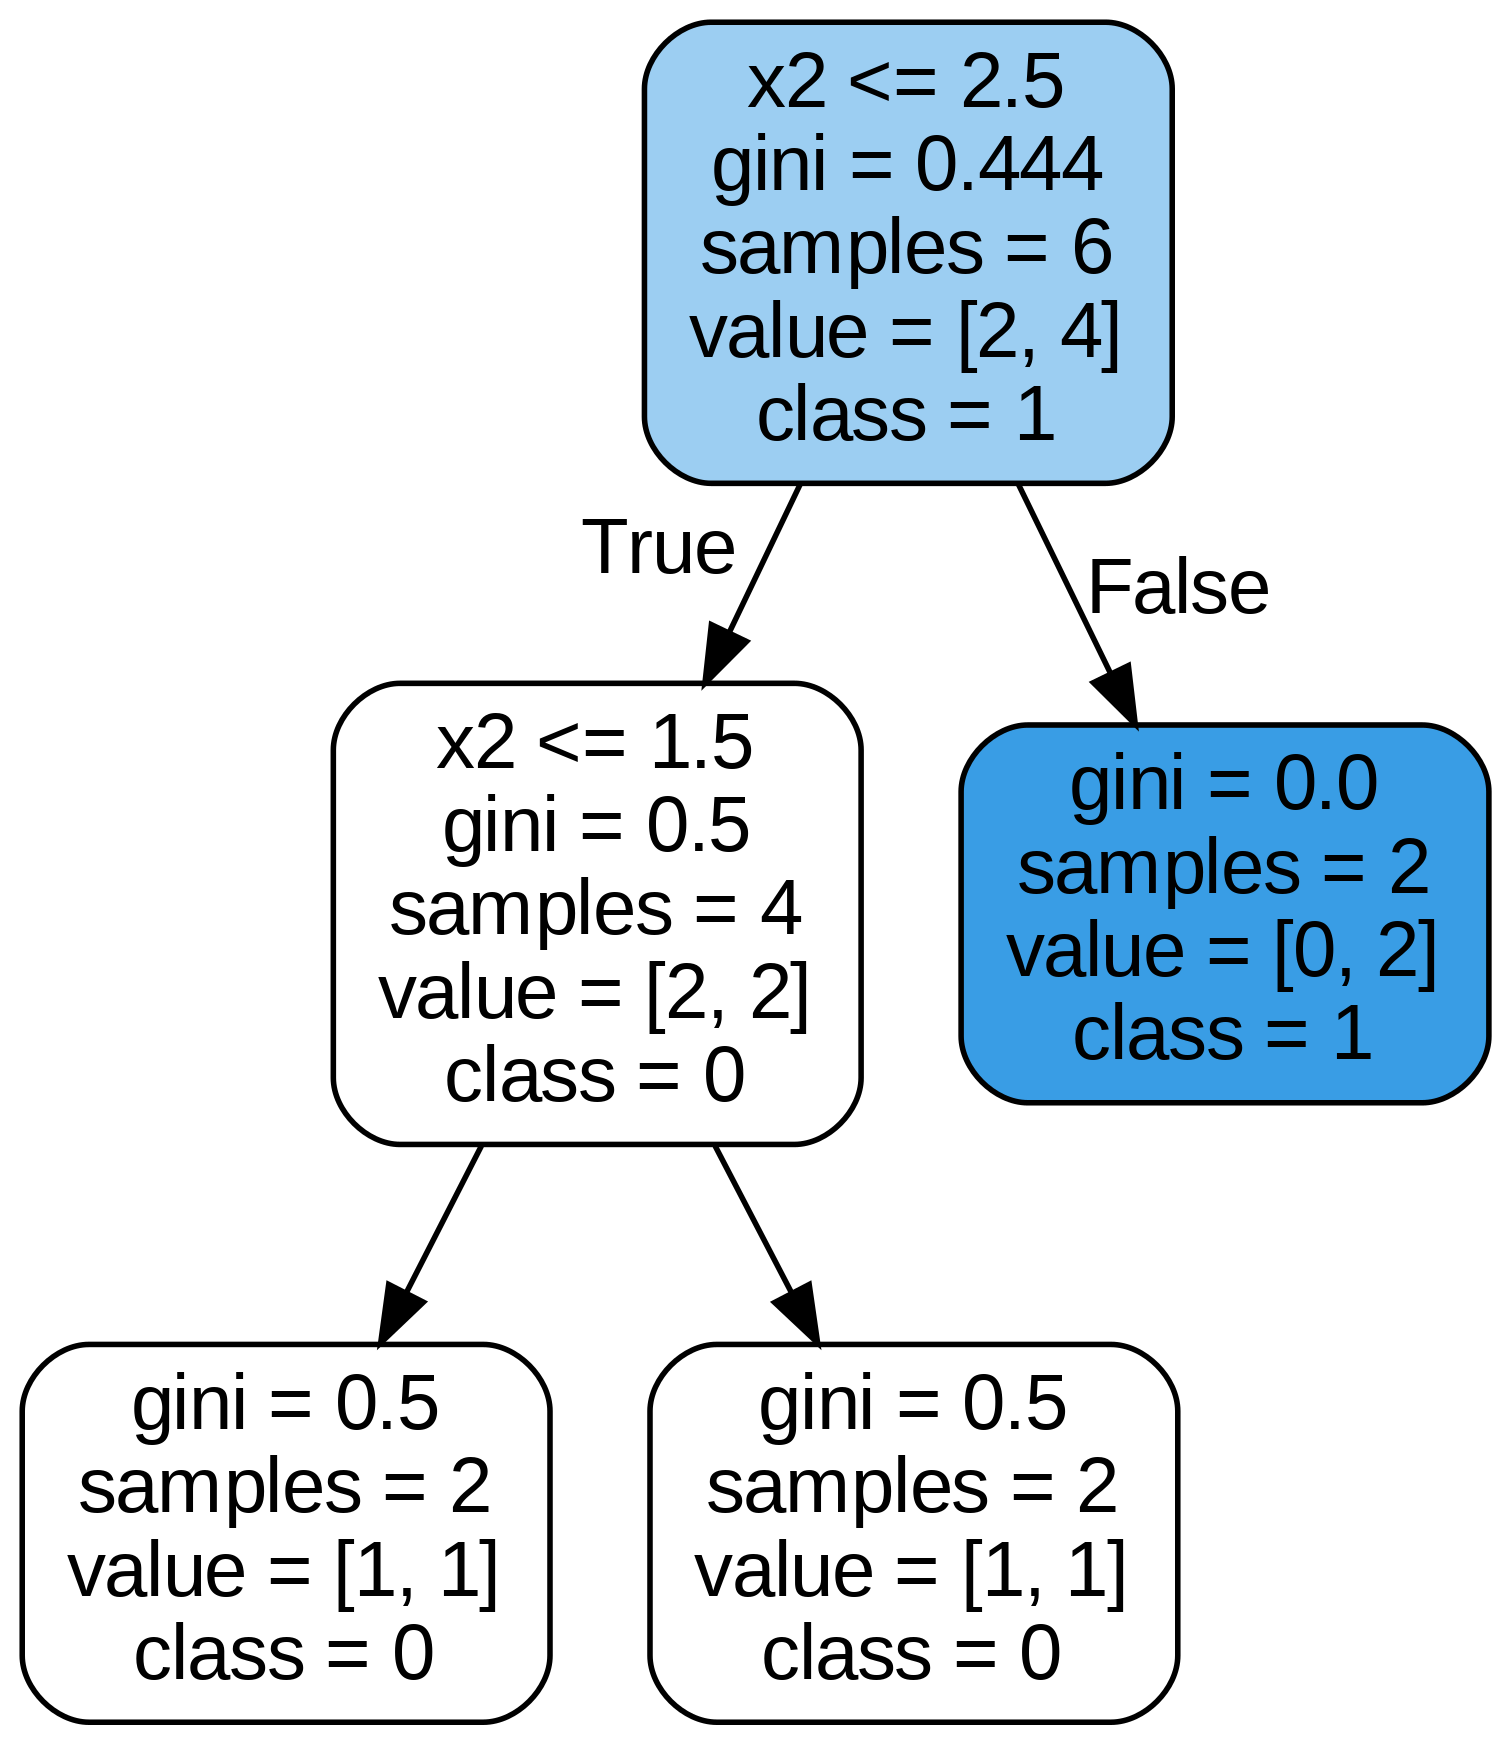

In [79]:
# Export as dot
export_graphviz(short_tree, 'shorttree.dot', rounded = True,
                feature_names = ['x1', 'x2'],
                class_names = ['0', '1'], filled = True)

call(['dot', '-Tpng', 'shorttree.dot', '-o', 'shorttree.png', '-Gdpi=400']);
Image('shorttree.png')

# Real Dataset

[Available Here](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training.

The problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy is not a useful metric when dealing with an imbalanced problem.

## Data Cleaning

We'll read the data in and do a little cleaning.

In [80]:
import pandas as pd
df = pd.read_csv('2015.csv').sample(100000, random_state = RSEED)
df.head()

_STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
383119    49.0     4.0  b'05192015'  b'05'  b'19'  b'2015'    1100.0   
55536      9.0     9.0  b'09232015'  b'09'  b'23'  b'2015'    1100.0   
267093    34.0    10.0  b'11052015'  b'11'  b'05'  b'2015'    1100.0   
319092    41.0     4.0  b'04062015'  b'04'  b'06'  b'2015'    1100.0   
420978    54.0     5.0  b'05112015'  b'05'  b'11'  b'2015'    1100.0   

               SEQNO          _PSU  CTELENUM  ...  _PAREC1  _PASTAE1  \
383119  2.015009e+09  2.015009e+09       NaN  ...      4.0       2.0   
55536   2.015005e+09  2.015005e+09       1.0  ...      2.0       2.0   
267093  2.015011e+09  2.015011e+09       NaN  ...      4.0       2.0   
319092  2.015002e+09  2.015002e+09       1.0  ...      2.0       2.0   
420978  2.015004e+09  2.015004e+09       NaN  ...      1.0       1.0   

        _LMTACT1  _LMTWRK1  _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  \
383119       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
55536        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
267093       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
319092       2.0       2.0       3.0       1.0       1.0       2.0       1.0   
420978       3.0       3.0       4.0       1.0       1.0       NaN       NaN   

        _AIDTST3  
383119       2.0  
55536        2.0  
267093       2.0  
319092       2.0  
420978       2.0  

[5 rows x 330 columns]

In [81]:
df = df.select_dtypes('number')

### Label Distribution

In [82]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

label
1.0    81140
0.0    18579
Name: count, dtype: int64

The label imbalanced means that accuracy is not the best metric.

Below, we drop a number of columns that we should not use for modeling (they are different versions of the labels).

In [83]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2',
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

## Split Data into Training and Testing Set

We'll save 30% of the examples for testing.

In [84]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels,
                                                          stratify = labels,
                                                          test_size = 0.3,
                                                          random_state = RSEED)

#### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values.

In [85]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

In [86]:
train.shape

(69803, 313)

In [87]:
test.shape

(29916, 313)

## Decision Tree on Real Data

First, we'll train the decision tree on the data. Let's leave the depth unlimited and see if we get overfitting!

In [88]:
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 10807 nodes with maximum depth 36.


## Assess Decision Tree Performance

Given the number of nodes in our decision tree and the maximum depth, we expect it has overfit to the training data. This means it will do much better on the training data than on the testing data.

In [89]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [90]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.671783162768723


In [91]:
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Baseline ROC AUC: 0.5


Our model does outperform a baseline guess, but we can see it has severely overfit to the training data, acheiving perfect ROC AUC.

## Evaluate the Decision Tree

We'll write a short function that calculates a number of metrics for the baseline (guessing the most common label in the training data), the testing predictions, and the training predictions. The function also plots the ROC curve where a better model is to the left and towards the top.

In [92]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""

    baseline = {}

    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5

    results = {}

    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)

    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)

    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [93]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({np.float64(1.0): 23890, np.float64(0.0): 6026})
Counter({np.float64(1.0): 23890, np.float64(0.0): 6026})


Recall Baseline: 1.0 Test: 0.86 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.67 Train: 1.0


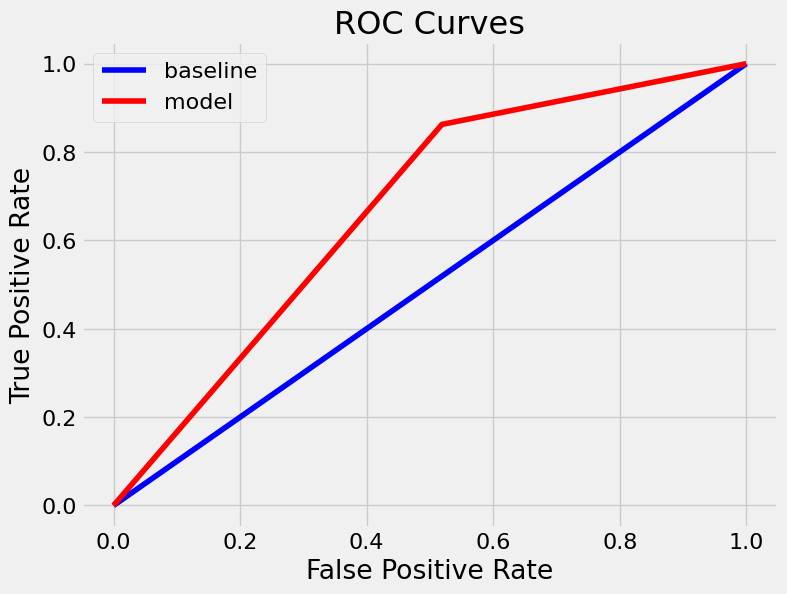

In [94]:
evaluate_model(predictions, probs, train_predictions, train_probs)

There we can see the problem with a single decision tree where the maximum depth is not limited: __severe overfitting to the training data__.

Another method to inspect the performance of a classification model is by making a confusion matrix.

### Confusion Matrix

In [95]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 2681  2893]
 [ 3345 20997]]


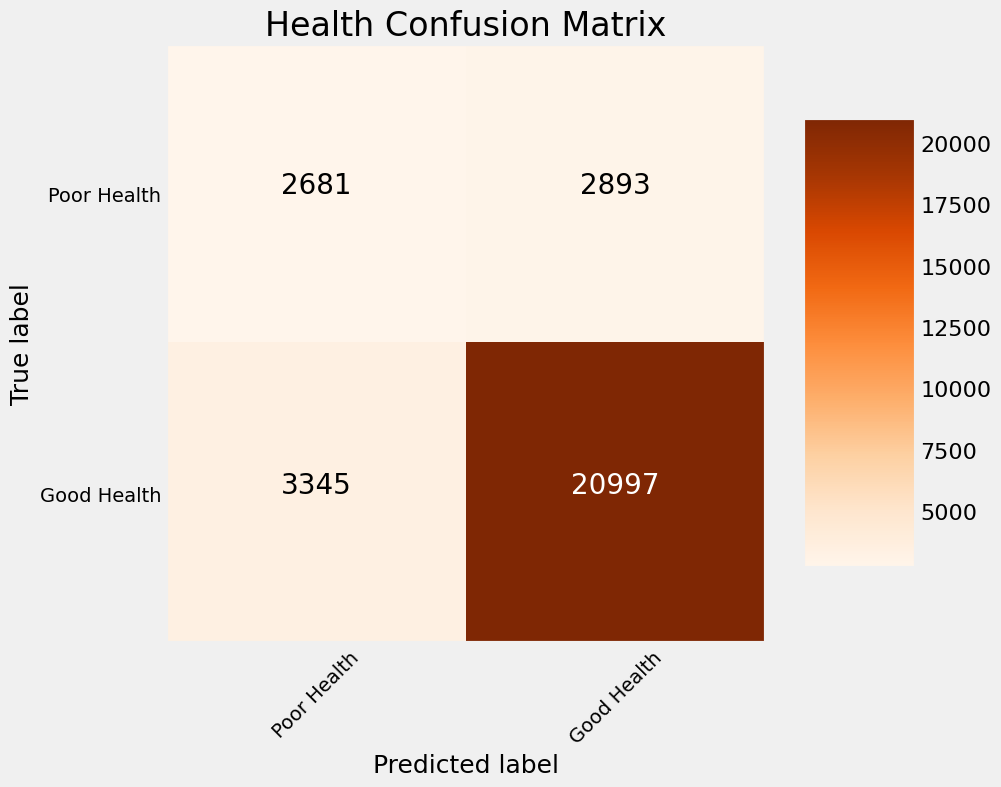

In [96]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

This shows the classifications predicted by the model on the test data along with the real labels. We can see that our model has many false negatives (predicted good health but actually poor health) and false positives (predicted poor health but actually good health).

### Feature Importances

Finally, we can take a look at the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used.

In [97]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

feature  importance
62   DIFFWALK    0.162514
58   QLACTLM2    0.036763
54   INTERNET    0.021851
245     _BMI5    0.020900
51    EMPLOY1    0.018745

We won't go through the definitions here, but you can look through the [data dictionary](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system#2015_formats.json) to determine the meaning of each feature.

### Visualize Full Tree

As before, we can look at the decision tree on the data. This time, we have to limit the maximum depth otherwise the tree will be too large and cannot be converted and displayed as an image.

In [98]:
# Save tree as dot file
export_graphviz(tree, 'tree_real_data.dot', rounded = True,
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

# Convert to png
call(['dot', '-Tpng', 'tree_real_data.dot', '-o', 'tree_real_data.png', '-Gdpi=200'])

# Visualize
Image(filename='tree_real_data.png')

We can see that our model is extremely deep and has many nodes. To reduce the variance of our model, we could limit the maximum depth or the number of leaf nodes. Another method to reduce the variance is to use more trees, each one trained on a random sampling of the observations. This is where the random forest comes into play.

# Random Forest

Now we can move on to a more powerful model, the random forest. This takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. In Random forest, each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

Creating and training a random forest in extremely easy in Scikit-Learn. The cell below is all you need.

In [99]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100,
                               random_state=RSEED,
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.7s finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.

In [100]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)

print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 13396
Average maximum depth 46


We see that each decision tree in the forest has many nodes and is extremely deep. However, even though each individual decision tree may overfit to a particular subset of the training data, the idea is that the overall random forest should have a reduced variance.

## Random Forest Results

In [101]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


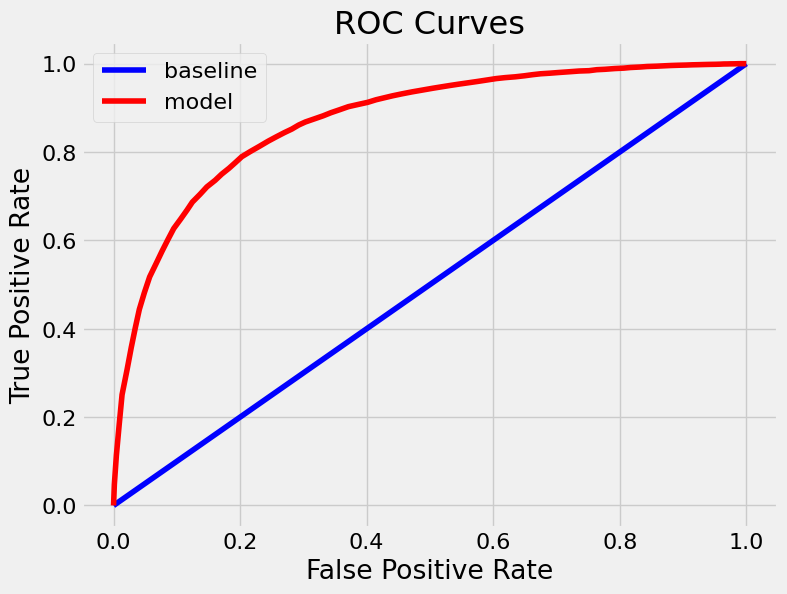

In [102]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

The model still achieves perfect measures on the training data, but this time, the testing scores are much better. If we compare the ROC AUC, we see that the random forest does significantly better than a single decision tree.

Confusion matrix, without normalization
[[ 2438  3136]
 [ 1043 23299]]


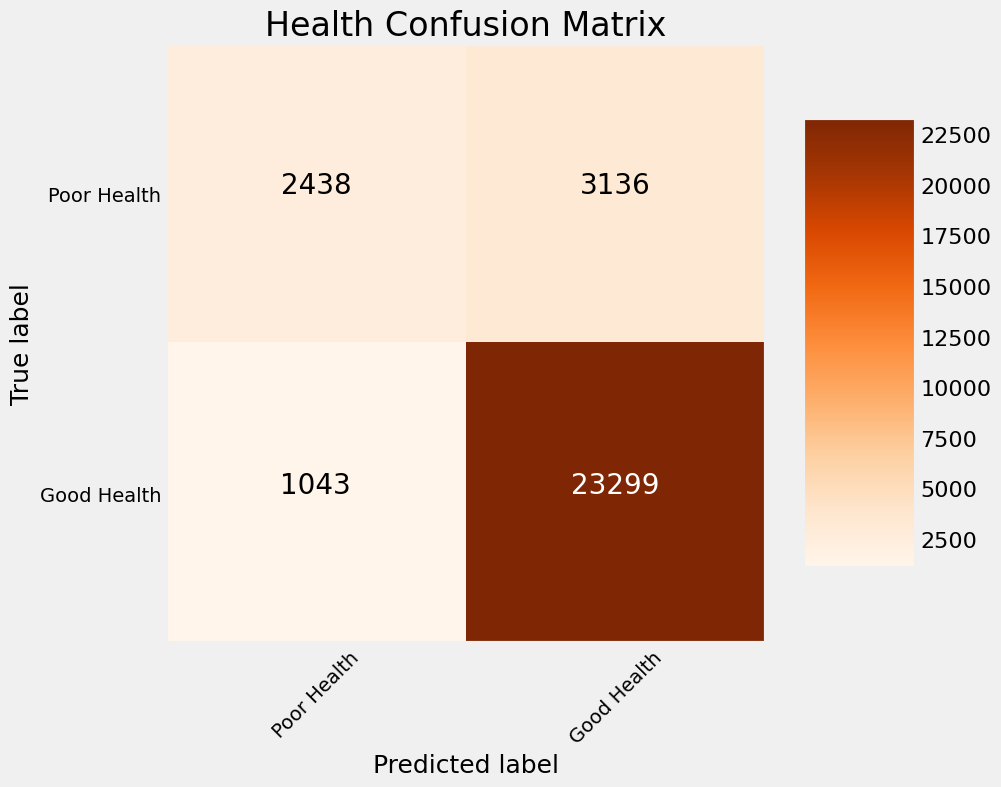

In [103]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

Compared to the single decision tree, the model has fewer false postives although more false negatives. __Overall, the random forest does significantly better than a single decision tree__. This is what we expected!

In [104]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

feature  importance
62   DIFFWALK    0.036200
58   QLACTLM2    0.030694
51    EMPLOY1    0.024156
64   DIFFALON    0.022699
59   USEEQUIP    0.016922
61     DECIDE    0.016271
307  _LMTSCL1    0.013424
53    INCOME2    0.011929
37   CHCCOPD1    0.011506
245     _BMI5    0.011497

Our model does pretty well! Compared to the single decision tree, the random forest is much better able to generalize to new data.